# Import liberaries and functions

In [14]:
import numpy as np
import pandas as pd
import random
import zipfile
import tensorflow as tf
import seaborn as sns
import sys, os, datetime
from PIL import Image, ImageEnhance
from skimage.util import random_noise
from collections import defaultdict
from keras.preprocessing import image
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from keras.models import load_model
from tensorflow.keras import mixed_precision
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Check for GPUs usage

In [2]:
# Create a MirroredStrategy instance
strategy = tf.distribute.MirroredStrategy()
print(f'Number of devices: {strategy.num_replicas_in_sync}')

Number of devices: 2


**GPU check**

In [3]:
# Check if GPU is available
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Get GPU details
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)

# Set the global policy for mixed precision to use 'mixed_float16'
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

# Enable XLA (Accelerated Linear Algebra) JIT (Just-In-Time) compilation
# to improve performance by optimizing TensorFlow operations
tf.config.optimizer.set_jit(True)

Num GPUs Available:  2
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')


# Read data using data generator

**Parameters**

In [4]:
training_path = '/kaggle/input/teeth-dataset/Teeth_Dataset/Training'
testing_path = '/kaggle/input/teeth-dataset/Teeth_Dataset/Testing'
validation_path = '/kaggle/input/teeth-dataset/Teeth_Dataset/Validation'
disease_classes = ["CaS", "CoS", "Gum", "MC", "OC", "OLP", "OT"]
size = 96

**Data Generator**

In [5]:
# Training data generator
train_datagen = ImageDataGenerator(rescale=1./255,)

# Testing data generator
test_val_datagen = ImageDataGenerator(rescale=1./255)

# Load the training data
train_generator = train_datagen.flow_from_directory(
    training_path,
    target_size=(size,size),
    batch_size=64,
    class_mode='categorical',
    classes=disease_classes,
    shuffle=True
)

# Load the testing data
test_generator = test_val_datagen.flow_from_directory(
    testing_path,
    target_size=(size,size),
    batch_size=64,
    class_mode='categorical',
    classes=disease_classes,
    shuffle=True
)

# Load the validation data
validation_generator = test_val_datagen.flow_from_directory(
    validation_path,
    target_size=(size,size),
    batch_size=64,
    class_mode='categorical',
    classes=disease_classes,
    shuffle=True
)

Found 3087 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.
Found 1028 images belonging to 7 classes.


**View number of images in each disease**

In [6]:
import numpy as np

def count_images(generator, dataset_name, disease_classes):
    class_counts = defaultdict(int)

    # Total number of samples
    num_samples = generator.samples
    num_batches = num_samples // generator.batch_size + 1

    # Count images per class
    for _ in range(num_batches):
        images, labels = next(generator)
        labels = np.argmax(labels, axis=1)  # Convert one-hot encoded labels to class indices
        
        # Count the number of images for each class in the current batch
        for label in labels:
            for disease_name, index in generator.class_indices.items():
                if index == label:
                    class_counts[disease_name] += 1

    # Print counts for each disease
    print(f"{dataset_name} Data:")
    for disease in disease_classes:
        count = class_counts.get(disease, 0)
        print(f"Disease: {disease}, Number of Images: {count}")
    print()

count_images(train_generator, "Training", disease_classes)
count_images(test_generator, "Testing", disease_classes)
count_images(validation_generator, "Validation", disease_classes)

Training Data:
Disease: CaS, Number of Images: 480
Disease: CoS, Number of Images: 450
Disease: Gum, Number of Images: 360
Disease: MC, Number of Images: 540
Disease: OC, Number of Images: 324
Disease: OLP, Number of Images: 540
Disease: OT, Number of Images: 393

Testing Data:
Disease: CaS, Number of Images: 160
Disease: CoS, Number of Images: 149
Disease: Gum, Number of Images: 120
Disease: MC, Number of Images: 180
Disease: OC, Number of Images: 108
Disease: OLP, Number of Images: 180
Disease: OT, Number of Images: 131

Validation Data:
Disease: CaS, Number of Images: 160
Disease: CoS, Number of Images: 149
Disease: Gum, Number of Images: 120
Disease: MC, Number of Images: 180
Disease: OC, Number of Images: 108
Disease: OLP, Number of Images: 180
Disease: OT, Number of Images: 131



**View samples from the data**

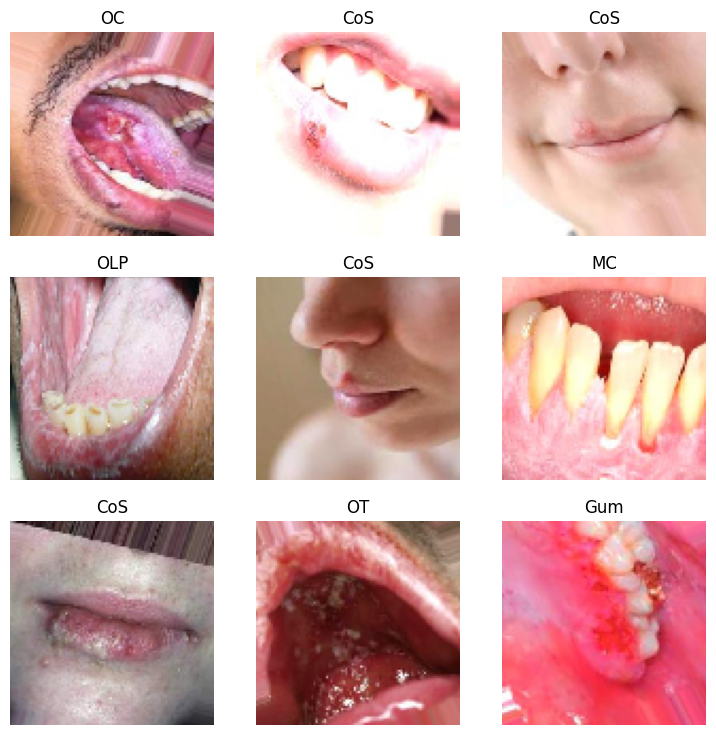

In [7]:
# Define the target number of images to display
target_num_images = 9

# Get a batch of augmented data
train_images, train_labels = next(train_generator)

# Denormalize images for visualization
train_images = train_images * 255.0
train_images = np.clip(train_images, 0, 255).astype(np.uint8)

# Convert one-hot encoded labels to class indices
train_labels = np.argmax(train_labels, axis=1)

# Calculate the number of rows and columns for the plot
num_rows = int(np.sqrt(target_num_images))
num_cols = int(np.ceil(target_num_images / num_rows))

# Display the target number of images from the batch
plt.figure(figsize=(num_cols * 3, num_rows * 3))
for i in range(min(target_num_images, len(train_images))):  # Ensure we do not exceed the batch size
    plt.subplot(num_rows, num_cols, i + 1)
    plt.imshow(train_images[i])
    plt.title(disease_classes[train_labels[i]])  # Set title as the label of the image
    plt.axis('off')
plt.show()

# Pretrained model
**MobileNet V2**

In [8]:
def MobileNetV2_finetuning(out_dim: int, learning_rate: float) -> tf.keras.Model:
    # Load the base model with imagenet weights without the top layer
    base_model = tf.keras.applications.MobileNetV2(
        include_top=False, weights='imagenet', input_shape=(size, size, 3))
    base_model.trainable = False  # Freeze the model initially
    # base_model.summary(show_trainable=True, expand_nested=True)

    # Define input
    input = tf.keras.Input(shape=(size, size, 3), name="input")

    # Add new layers on top of the model
    x = base_model(input, training=False)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x) 
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    predictions = tf.keras.layers.Dense(out_dim, activation='softmax', name="output")(x)
    model = tf.keras.models.Model(inputs=input, outputs=predictions, name="ft_net")
    # model.summary(show_trainable=True, expand_nested=True)

    model = compile_model(model, learning_rate)
    return model


def compile_model(model: tf.keras.Model, learning_rate: float) -> tf.keras.Model:
    model.compile(tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def unfreeze_base_layers(model: tf.keras.Model, layers: int, learning_rate: float) -> tf.keras.Model:
    base_model = model.layers[1]
    
    # Unfreeze the last layers
    for layer in base_model.layers[-min(len(base_model), layers):]:
        layer.trainable = True
        
    # Compile the model again to apply the changes
    model = compile_model(model, learning_rate)
    return model

In [9]:
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',factor=0.5,patience=3,min_lr=0.001,verbose=1)

model_checkpoint = ModelCheckpoint(
    filepath='MobileNetV2_best.keras',monitor='val_loss',save_best_only=True, mode='min',verbose=1)

early_stopping = EarlyStopping(
    monitor='val_loss',patience=5,verbose=1,mode='min',restore_best_weights=True)

model = MobileNetV2_finetuning(out_dim=len(disease_classes), learning_rate=0.001)
history = model.fit(train_generator, epochs=30,validation_data=validation_generator, 
                          callbacks=[lr_scheduler, model_checkpoint, ])

loss, accuracy = model.evaluate(test_generator)
print(f'Best Model - Test Loss: {loss}, Accuracy: {accuracy}')

# model = load_model('/kaggle/working/MobileNetV2_best.keras')

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725044625.133310     614 service.cc:145] XLA service 0x78f908011de0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725044625.133364     614 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725044625.133367     614 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/49 ━━━━━━━━━━━━━━━━━━━━ 12:54 16s/step - accuracy: 0.2031 - loss: 3.3118

I0000 00:00:1725044634.433119     614 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


46/49 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - accuracy: 0.3074 - loss: 2.3241
Epoch 1: val_loss improved from inf to 0.85070, saving model to MobileNetV2_best.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 37s 429ms/step - accuracy: 0.3181 - loss: 2.2738 - val_accuracy: 0.7062 - val_loss: 0.8507 - learning_rate: 0.0010
Epoch 2/30
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.6895 - loss: 0.8834
Epoch 2: val_loss improved from 0.85070 to 0.64830, saving model to MobileNetV2_best.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.6899 - loss: 0.8812 - val_accuracy: 0.7588 - val_loss: 0.6483 - learning_rate: 0.0010
Epoch 3/30
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7565 - loss: 0.6725
Epoch 3: val_loss improved from 0.64830 to 0.52528, saving model to MobileNetV2_best.keras
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 160ms/step - accuracy: 0.7565 - loss: 0.6720 - val_accuracy: 0.8084 - val_loss: 0.5253 - learning_rate: 0.0010
Epoch 4/30
47/49 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accura

# MobilNet V2 Visualizations


**Training and Validation Accuracy**

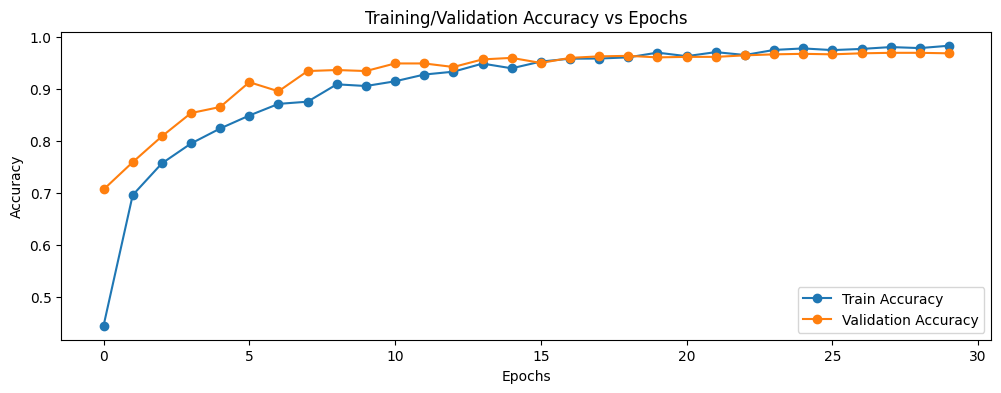

In [10]:
# Extract metrics from history
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


# Create subplots
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

# Plot training and validation accuracy
ax.set_title('Training/Validation Accuracy vs Epochs')
ax.plot(train_accuracy, 'o-', label='Train Accuracy')
ax.plot(val_accuracy, 'o-', label='Validation Accuracy')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend(loc='best')

**Training and Validation Loss**

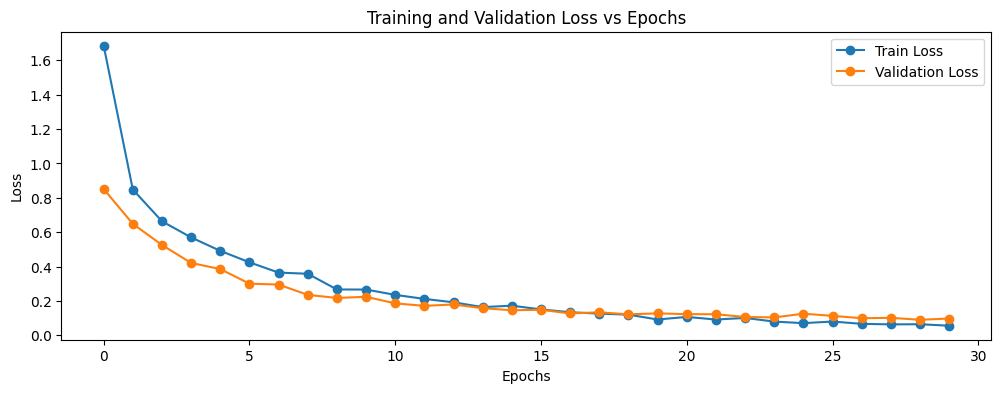

In [11]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

# Plot training and validation loss
ax.plot(train_loss, 'o-', label='Train Loss')
ax.plot(val_loss, 'o-', label='Validation Loss')
ax.set_title('Training and Validation Loss vs Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend(loc='best')

**Learning rate and Epochs**

In [ ]:
# learning_rate = history.history.get('lr', [])

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))

# # Plot learning rate
# ax.set_title('Learning Rate vs Epochs')
# ax.plot(learning_rate, 'o-', label='Learning Rate')
# ax.set_xlabel('Epochs')
# ax.set_ylabel('Learning Rate')
# ax.legend(loc='best')

**Display Confusion Matrix**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


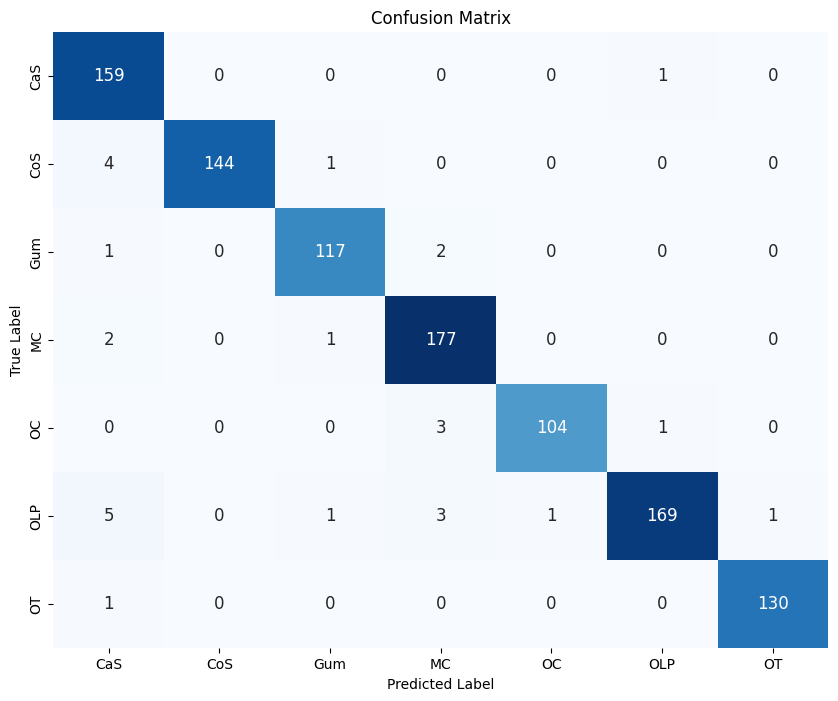

In [15]:
def get_predictions_and_labels(generator):
    all_preds = []
    all_labels = []
    
    for batch_images, batch_labels in generator:
        # Predict batch
        batch_preds = model.predict(batch_images)
        
        # If labels are one-hot encoded, use np.argmax to get the class indices
        if batch_labels.ndim > 1:
            batch_labels = np.argmax(batch_labels, axis=1)
        
        # Append predictions and labels
        all_preds.extend(np.argmax(batch_preds, axis=1))
        all_labels.extend(batch_labels)
        
        # Stop if we've processed all data
        if len(all_preds) >= generator.samples:
            break
    
    return np.array(all_labels), np.array(all_preds)

# Get true labels and predictions
y_true, y_pred = get_predictions_and_labels(test_generator)

# Compute the confusion matrix
cf_mtx = confusion_matrix(y_true, y_pred)

# Create a DataFrame for better plotting
class_labels = list(test_generator.class_indices.keys())
cf_df = pd.DataFrame(cf_mtx, index=class_labels, columns=class_labels)

# Plot the confusion matrix using a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cf_df, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 12})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


**Classification report**

In [16]:
print(classification_report(y_true, y_pred, target_names=test_generator.class_indices.keys()))

              precision    recall  f1-score   support

         CaS       0.92      0.99      0.96       160
         CoS       1.00      0.97      0.98       149
         Gum       0.97      0.97      0.97       120
          MC       0.96      0.98      0.97       180
          OC       0.99      0.96      0.98       108
         OLP       0.99      0.94      0.96       180
          OT       0.99      0.99      0.99       131

    accuracy                           0.97      1028
   macro avg       0.98      0.97      0.97      1028
weighted avg       0.97      0.97      0.97      1028

